In [ ]:
import pandas as pd
from pathlib import Path
from typing import List

def create_target_variants(
    original_feather: str,
    filter_parquet: str,
    columns_to_extract: List[str],
    output_folder: str,
    note_id_col: str = "note_id",
    target_col: str = "target",
):
    """
    Filter original_feather to rows in filter_parquet and create separate files 
    for each column in columns_to_extract, renaming it as 'target' and removing
    the existing target column.
    """
    # Load datasets
    df_orig = pd.read_feather(original_feather)
    df_filter = pd.read_parquet(filter_parquet)

    # Filter original dataframe to rows present in parquet
    df_filtered = df_orig[df_orig[note_id_col].isin(df_filter[note_id_col])]
    
    # Make output folder
    base_path = Path(output_folder)
    base_path.mkdir(parents=True, exist_ok=True)

    for col in columns_to_extract:
        # Create subfolder for this column
        subfolder = base_path / col
        subfolder.mkdir(exist_ok=True)

        # Create copy and replace target column
        df_copy = df_filtered.copy()
        if target_col in df_copy.columns:
            df_copy = df_copy.drop(columns=[target_col])
            df_copy = df_copy.drop(columns=['icd10_diag'])
            df_copy = df_copy.drop(columns=['num_targets'])
        df_copy[target_col] = df_filter.set_index(note_id_col).loc[df_copy[note_id_col], col].values
        df_copy['icd10_diag'] = df_filter.set_index(note_id_col).loc[df_copy[note_id_col], col].values
        df_copy["num_targets"] = df_filter.set_index(note_id_col).loc[df_copy[note_id_col], col].apply(lambda x: len(x)).values


        # Save feather with the original file name
        out_path = subfolder / Path(original_feather).name
        df_copy.reset_index(drop=True).to_feather(out_path)
        print(f"Saved {col} -> {out_path}")

# Example usage
create_target_variants(
    original_feather="mimiciv_icd10.feather",
    filter_parquet="../2-explainable-medical-coding/explainable_medical_coding/data/processed/mimiciv_filtered.parquet",
    columns_to_extract=["mimic_codes_y", "llm_validated_y", "llm_accurate_y"],
    output_folder="filtered_targets"
)


Saved mimic_codes_y -> filtered_targets/mimic_codes_y/mimiciv_icd10.feather
Saved llm_validated_y -> filtered_targets/llm_validated_y/mimiciv_icd10.feather
Saved llm_accurate_y -> filtered_targets/llm_accurate_y/mimiciv_icd10.feather


In [4]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def llm_rare_code_bias_diagnostic(
    original_feather: str,
    filter_parquet: str,
    mimic_col: str = "mimic_codes_y",
    llm_col: str = "llm_validated_y",
    note_id_col: str = "note_id",
    plot: bool = True
):
    """
    Diagnose whether LLM tends to remove rare codes more often.
    Reads the original feather and filter parquet to produce a filtered dataset.
    
    Returns:
        freq_df: DataFrame with per-code statistics
        corr: Spearman correlation between rarity and removal
    """
    # Load data
    df_orig = pd.read_feather(original_feather)
    df_filter = pd.read_parquet(filter_parquet)
    
    # Filter original df to only note_ids in filter
    df_filtered = df_orig[df_orig[note_id_col].isin(df_filter[note_id_col])].copy()
    
    # Merge in filter columns
    df_filtered = df_filtered.merge(df_filter[[note_id_col, mimic_col, llm_col]], on=note_id_col, how="left")
    
    # Parse code lists robustly
    def _parse_list(x):
        """
        Robust parser for ICD code columns.
        Works for:
            - list / tuple / set
            - np.ndarray
            - string representations of lists
            - NaN
        Returns a list of strings.
        """
        import numpy as np
        import ast

        # If x is array-like (list, tuple, set, ndarray)
        if isinstance(x, (list, tuple, set, np.ndarray)):
            return [str(i) for i in x]

        # If x is a scalar NaN
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return []

        # If x is string
        if isinstance(x, str):
            x_strip = x.strip()
            # Try literal_eval for Python-like list string
            if x_strip.startswith("[") or x_strip.startswith("("):
                try:
                    parsed = ast.literal_eval(x_strip)
                    if isinstance(parsed, (list, tuple, set)):
                        return [str(i) for i in parsed]
                except:
                    pass
            # Fallback: split on common separators
            for sep in [",", ";", "|"]:
                if sep in x_strip:
                    return [s.strip() for s in x_strip.split(sep) if s.strip()]
            # Treat as single code string
            return [x_strip] if x_strip else []

        # Catch-all fallback
        try:
            return [str(i) for i in list(x)]
        except:
            return []
    
    df_filtered["_parsed_mimic"] = df_filtered[mimic_col].apply(_parse_list)
    df_filtered["_parsed_llm"] = df_filtered[llm_col].apply(_parse_list)
    
    # Count code frequencies
    counter_mimic = Counter()
    counter_llm = Counter()
    for lst in df_filtered["_parsed_mimic"]:
        counter_mimic.update(lst)
    for lst in df_filtered["_parsed_llm"]:
        counter_llm.update(lst)
    
    # Build per-code DataFrame
    codes = sorted(set(counter_mimic.keys()) | set(counter_llm.keys()))
    rows = []
    for c in codes:
        f_orig = counter_mimic.get(c, 0)
        f_llm = counter_llm.get(c, 0)
        retention = f_llm / f_orig if f_orig > 0 else np.nan
        removal = 1.0 - retention if f_orig > 0 else np.nan
        rarity = 1.0 / np.log1p(f_orig)  # smaller freq => higher rarity
        rows.append({"code": c, "freq_orig": f_orig, "freq_llm": f_llm, "retention": retention, "removal": removal, "rarity": rarity})
    
    freq_df = pd.DataFrame(rows)
    
    # Compute Spearman correlation between rarity and removal
    valid_mask = freq_df["removal"].notna()
    corr, pval = spearmanr(freq_df.loc[valid_mask, "rarity"], freq_df.loc[valid_mask, "removal"])
    
    print(f"Spearman correlation between rarity and LLM removal: {corr:.3f} (p={pval:.3g})")
    if corr > 0:
        print("→ Rare codes tend to be removed more by the LLM (bias exists).")
    elif corr < 0:
        print("→ Rare codes tend to be kept more than frequent ones (inverse bias).")
    else:
        print("→ No clear bias detected.")
    
    if plot:
        plt.figure(figsize=(6,4))
        plt.scatter(freq_df["rarity"], freq_df["removal"], alpha=0.6)
        plt.xlabel("Rarity (1 / log1p(freq))")
        plt.ylabel("Removal rate (1 - retention)")
        plt.title("LLM removal vs code rarity")
        plt.grid(True)
        plt.show()
    
    return freq_df, corr


Spearman correlation between rarity and LLM removal: -0.246 (p=4.11e-62)
→ Rare codes tend to be kept more than frequent ones (inverse bias).


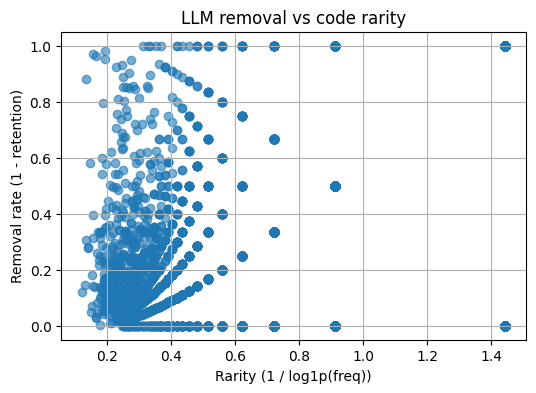

In [5]:
freq_df, corr = llm_rare_code_bias_diagnostic(
    original_feather="mimiciv_icd10.feather",
    filter_parquet="mimiciv_filtered.parquet",
    mimic_col="mimic_codes_y",
    llm_col="llm_validated_y"
)


# LLM Rare-Code Removal Diagnostic Steps

## 1. Parse code lists
- `mimic_codes_y`: original ICD codes per row (list of strings)
- `llm_validated_y`: codes the LLM kept (list of strings)
- Parse each row into a Python list of strings, handling NaN, arrays, or string representations of lists.

---

## 2. Count frequencies
- For each unique code:
  - freq_orig = number of times the code appears in `mimic_codes_y` across all rows
  - freq_llm = number of times the code appears in `llm_validated_y` across all rows

---

## 3. Compute retention and removal
- retention = freq_llm / freq_orig  # fraction of times the code is kept
- removal = 1 - retention           # fraction of times the code is removed

---

## 4. Compute rarity
- rarity = 1 / log1p(freq_orig)  
- Rare codes (small freq_orig) have higher rarity values

---

## 5. Correlation analysis
- Compute Spearman correlation between `rarity` and `removal`
  - Positive correlation → rare codes are removed more often
  - Negative correlation → rare codes are kept more often (inverse bias)
  - Near zero → no clear bias

---

## 6. Visualization
- Scatter plot:
  - x-axis: rarity
  - y-axis: removal rate
- This helps visually assess whether rare codes are more likely to be removed.